# Machine Learning Project #1

Work by:

* Bárbara Simões Neto - 202106176 - M:DS - 33%
* Beatriz Castro Silva - aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa - M:DS - 33%
* Rodrigo Couto - 202104696 - M:DS - 33%


In [80]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import learning_curve
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.base import clone
from sklearn.preprocessing import OrdinalEncoder
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs, make_gaussian_quantiles
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC  
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import warnings
warnings.filterwarnings('ignore')

## Generate DataSets

In [81]:
def generate_mixed_dataset(n_samples, n_features, n_categorical, n_ordinal, n_integer, 
                           n_classes, class_balance=None, noise=0.0, 
                           dataset_type='linear', random_state=42):

    np.random.seed(random_state)

    if dataset_type == 'linear':
        X, y = make_classification(n_samples=n_samples, n_features=n_features, 
                                  n_informative=n_features, n_redundant=0, 
                                  n_classes=n_classes, weights=class_balance, 
                                  flip_y=noise, random_state=random_state,class_sep=2)
    elif dataset_type == 'moons':
        X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
        if n_features > 2:
            extra_features = np.random.rand(n_samples, n_features - 2) * 100
            X = np.hstack([X, extra_features])
    elif dataset_type == 'circles':
        X, y = make_circles(n_samples=n_samples, noise=noise, random_state=random_state)
        if n_features > 2:
            extra_features = np.random.rand(n_samples, n_features - 2) * 100
            X = np.hstack([X, extra_features])
    elif dataset_type == 'blobs':
        X, y = make_blobs(n_samples=n_samples, centers=n_classes, cluster_std=noise*10, 
                          random_state=random_state)
        if n_features > 2:
            extra_features = np.random.rand(n_samples, n_features - 2) * 100
            X = np.hstack([X, extra_features])
    else:
        raise ValueError("Tipo de dataset não suportado. Use 'linear', 'moons', 'circles' ou 'blobs'.")

    categorical_data = np.random.choice(['A', 'B', 'C', 'D', 'E'], size=(n_samples, n_categorical))

    ordinal_data = np.random.randint(1, 6, size=(n_samples, n_ordinal))  

    integer_data = np.random.randint(0, 100, size=(n_samples, n_integer)) 

    data = np.hstack([X, categorical_data, ordinal_data, integer_data])

    columns = [f'Continuous_{i+1}' for i in range(n_features)] + \
              [f'Categorical_{i+1}' for i in range(n_categorical)] + \
              [f'Ordinal_{i+1}' for i in range(n_ordinal)] + \
              [f'Integer_{i+1}' for i in range(n_integer)]
    df = pd.DataFrame(data, columns=columns)

    df['Target'] = y

    for col in df.columns:
        if col.startswith('Continuous'):
            df[col] = df[col].astype(float)
        elif col.startswith('Ordinal') or col.startswith('Integer'):
            df[col] = df[col].astype(int)

    return df

This funcions has as inputs:

## Plot Decision Boundaries

In [82]:
def plot_decision_boundary(model, X, y, title):
    xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 100),
                         np.linspace(X[:,1].min()-1, X[:,1].max()+1, 100))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor="k")
    plt.title(title)

## Linear models and Discriminant Analysis

### Logistic Regression

#### Choose the adequate Dataset

In [83]:
X, y = make_classification(n_samples=200, 
                           n_features=2, 
                           n_classes=2,  
                           n_informative=2, 
                           n_redundant=0,  
                           n_clusters_per_class=1,
                           random_state=42,
                           class_sep=1.5,
                           weights=[0.7, 0.3]) 

df_logreg = pd.concat([pd.DataFrame(X), pd.Series(y)], axis=1)
df_logreg.columns = ["Feature 1", "Feature 2", "Class"]

np.random.seed(52)
outlier_indices = np.random.choice(df_logreg.index, size=10, replace=False)
df_logreg.loc[outlier_indices, "Feature 1"] = np.random.uniform(low=10, high=20, size=10)


np.random.seed(42)
outlier_indices = np.random.choice(df_logreg.index, size=10, replace=False)
df_logreg.loc[outlier_indices, "Feature 2"] = np.random.uniform(low=10, high=20, size=10)

df_logreg.head()

,Feature 1,Feature 2,Class
0,-0.864557,-0.442229,0
1,1.812935,3.270534,1
2,2.840428,2.920996,1
3,-4.722217,1.322205,0
4,1.444105,0.977241,1


#### Model

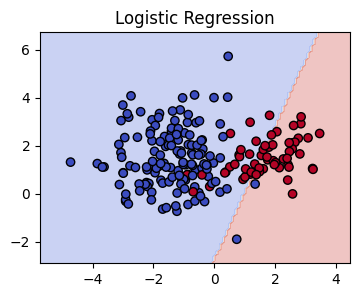

In [84]:
X_lr, y_lr = df_logreg.iloc[:, :-1].values, df_logreg.iloc[:, -1].values

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.3, random_state=42)

# Train models
log_reg = LogisticRegression(solver="lbfgs")

log_reg.fit(X_train_lr, y_train_lr)

# Predictions
y_pred_lr = log_reg.predict(X_test_lr)

# Accuracy
acc_lr = accuracy_score(y_test_lr, y_pred_lr)

plt.figure(figsize=(4,3))
plot_decision_boundary(log_reg, X, y, "Logistic Regression")
plt.show()

### LDA

#### Choose the adequate Dataset

In [85]:
X_lda, y_lda = make_classification(n_samples=300, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42, class_sep=0.9, flip_y=0.1, weights=[0.9, 0.1])
df_lda = pd.concat([pd.DataFrame(X_lda), pd.Series(y_lda)], axis=1)

df_lda.columns = ["Feature 1", "Feature 2", "Class"]

df_lda.head()

,Feature 1,Feature 2,Class
0,-1.408137,0.541881,0
1,2.052510,1.190190,1
2,-0.879469,0.905495,0
3,-0.822701,1.184172,0
4,-1.284593,0.729383,0


#### Model

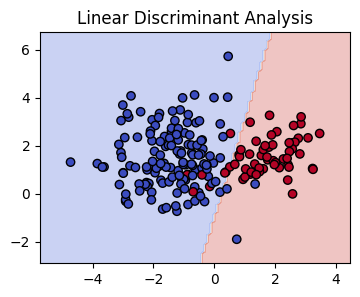

In [86]:
X_lda, y_lda = df_lda.iloc[:, :-1].values, df_lda.iloc[:, -1].values

X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(X_lda, y_lda, test_size=0.3, random_state=42)

# Train models
lda = LinearDiscriminantAnalysis()

lda.fit(X_train_lda, y_train_lda)

# Predictions
y_pred_lda = lda.predict(X_test_lda)

# Accuracy
acc_lda = accuracy_score(y_test_lda, y_pred_lda)

plt.figure(figsize=(4,3))
plot_decision_boundary(lda, X, y, "Linear Discriminant Analysis")
plt.show()

### QDA

#### Choose Adequate Dataset

In [87]:
X_qda, y_qda = make_gaussian_quantiles(mean=(0, 0), cov=2.0, n_samples=200, n_classes=2, random_state=42)

df_qda = pd.concat([pd.DataFrame(X), pd.Series(y)], axis=1)

df_qda.head()

,0,1,0
0,-0.864557,-0.442229,0
1,1.812935,3.270534,1
2,2.840428,2.920996,1
3,-4.722217,1.322205,0
4,1.444105,0.977241,1


#### Model

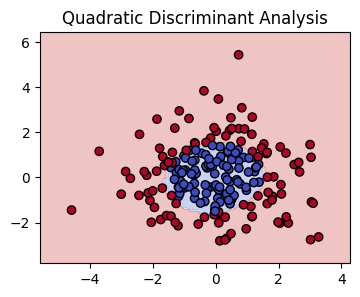

In [88]:
X_train_qda, X_test_qda, y_train_qda, y_test_qda = train_test_split(X_qda, y_qda, test_size=0.3, random_state=42)

qda = QuadraticDiscriminantAnalysis()

qda.fit(X_train_qda, y_train_qda)

y_pred_qda = qda.predict(X_test_qda)

plt.figure(figsize=(4,3))
plot_decision_boundary(qda, X_qda, y_qda, "Quadratic Discriminant Analysis")
plt.show()

### Bias, variance and total loss

In [89]:
model_names = ['Logistic Regression','LDA','QDA']
biases = []
variances = []
losses = []


loss_logreg, bias_logreg, var_logreg = bias_variance_decomp(
        log_reg, X_lr, y_lr, X_test_lr, y_test_lr,
        loss='0-1_loss', random_seed=13
    )

losses.append(loss_logreg)
biases.append(bias_logreg)
variances.append(var_logreg)

loss_lda, bias_lda, var_lda = bias_variance_decomp(
        lda, X_lda, y_lda, X_test_lda, y_test_lda,
        loss='0-1_loss', random_seed=13
    )

losses.append(loss_lda)
biases.append(bias_lda)
variances.append(var_lda)

loss_qda, bias_qda, var_qda = bias_variance_decomp(
        qda, X_qda, y_qda, X_test_qda, y_test_qda,
        loss='0-1_loss', random_seed=13
    )

losses.append(loss_qda)
biases.append(bias_qda)
variances.append(var_qda)


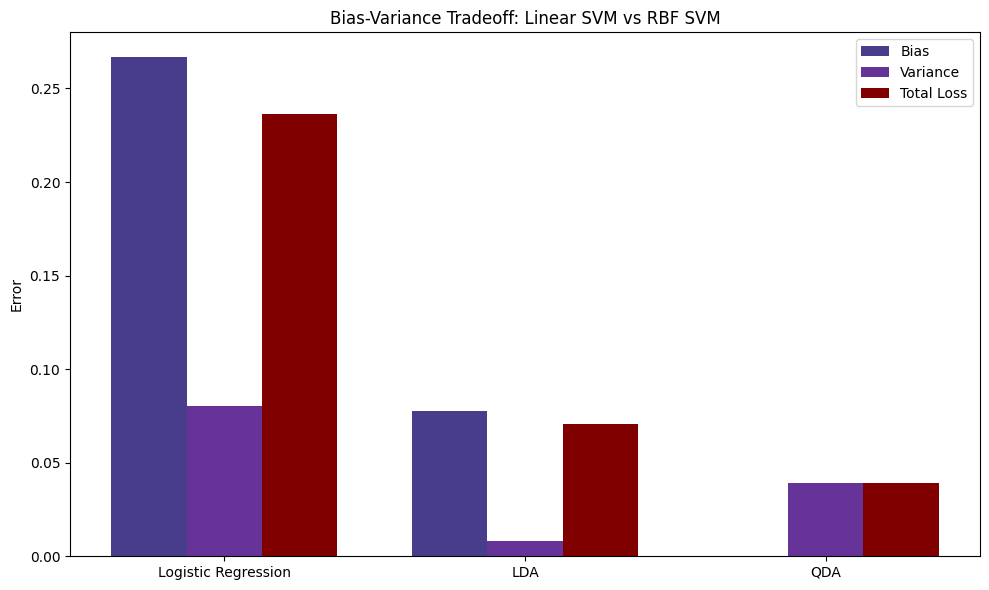

Model Comparison:

Logistic Regression:
Bias: 0.2667
Variance: 0.0801
Total Loss: 0.2364

LDA:
Bias: 0.0778
Variance: 0.0081
Total Loss: 0.0705

QDA:
Bias: 0.0000
Variance: 0.0391
Total Loss: 0.0391


In [90]:
x = np.arange(len(model_names))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, biases, width, label='Bias', color="darkslateblue")
plt.bar(x, variances, width, label='Variance', color="rebeccapurple")
plt.bar(x + width, losses, width, label='Total Loss', color="maroon")

plt.xticks(x, model_names)
plt.ylabel('Error')
plt.title('Bias-Variance Tradeoff: Linear SVM vs RBF SVM')
plt.legend()
plt.tight_layout()
plt.show()

print("Model Comparison:")
for name, bias, var, loss in zip(model_names, biases, variances, losses):
    print(f"\n{name}:")
    print(f"Bias: {bias:.4f}")
    print(f"Variance: {var:.4f}")
    print(f"Total Loss: {loss:.4f}")

### Cross Validation

In [91]:
cv_logreg = cross_val_score(log_reg, X_test_lr, y_test_lr, cv=8)
cv_lda = cross_val_score(lda, X_test_lda, y_test_lda, cv=8)
cv_qda = cross_val_score(qda, X_test_qda, y_test_qda, cv=8)


df_cv_scores_svm = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(8)],
    'Logistic Regression': cv_logreg,
    'LDA': cv_lda,
    'QDA': cv_qda
})


plt.figure(figsize=(8, 6))
plt.boxplot([cv_logreg,cv_lda,cv_qda], 
            tick_labels=['Logistic Regression', 'LDA', 'QDA'], 
            patch_artist=True,
            boxprops=dict(facecolor='royalblue'))
plt.ylabel('Accuracy Score')
plt.title('Cross-Validation Comparison: Logistic Regression, LDA and QDA (8 folds)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

TypeError: boxplot() got an unexpected keyword argument 'tick_labels'

<Figure size 800x600 with 0 Axes>

### Model Comparison

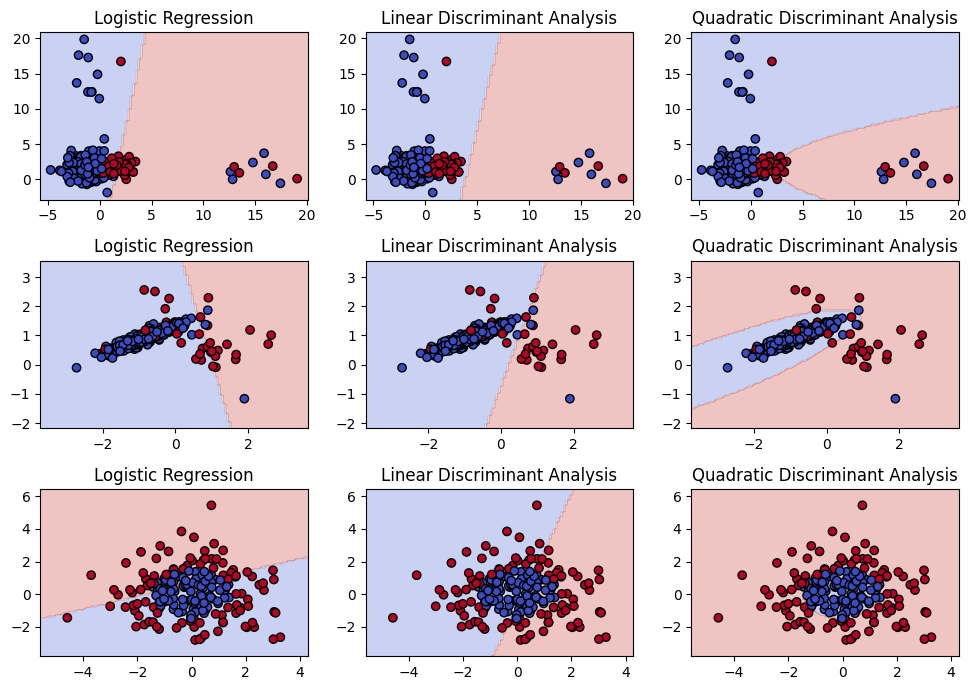

In [ ]:
plt.figure(figsize=(10,7))
plt.subplot(3,3,1)

plot_decision_boundary(log_reg, X_lr, y_lr, "Logistic Regression")
plt.subplot(3,3,2)
lda_lr = LinearDiscriminantAnalysis()
lda_lr.fit(X_lr, y_lr)
plot_decision_boundary(lda_lr, X_lr, y_lr, "Linear Discriminant Analysis")
plt.subplot(3,3,3)
qda_lr = QuadraticDiscriminantAnalysis()
qda_lr.fit(X_lr, y_lr)
plot_decision_boundary(qda_lr, X_lr, y_lr, "Quadratic Discriminant Analysis")

X, y = df_lda.iloc[:, :-1].values, df_lda.iloc[:, -1].values
plt.subplot(3,3,4)
lr_lda = LogisticRegression(solver="lbfgs")
lr_lda.fit(X_train_lda, y_train_lda)
plot_decision_boundary(lr_lda, X_lda, y_lda, "Logistic Regression")
plt.subplot(3,3,5)
plot_decision_boundary(lda, X_lda, y_lda, "Linear Discriminant Analysis")
plt.subplot(3,3,6)
qda_lda = QuadraticDiscriminantAnalysis()
qda_lda.fit(X_train_lda, y_train_lda)
plot_decision_boundary(qda_lda, X_lda, y_lda, "Quadratic Discriminant Analysis")

X, y = df_qda.iloc[:, :-1].values, df_qda.iloc[:, -1].values
plt.subplot(3,3,7)
lr_qda = LogisticRegression(solver="lbfgs")
lr_qda.fit(X_train_qda, y_train_qda)
plot_decision_boundary(lr_qda, X_qda, y_qda, "Logistic Regression")
plt.subplot(3,3,8)
lda_qda = LinearDiscriminantAnalysis()
lda_qda.fit(X_train_lda, y_train_lda)
plot_decision_boundary(lda, X_qda, y_qda, "Linear Discriminant Analysis")
plt.subplot(3,3,9)
plot_decision_boundary(qda, X_qda, y_qda, "Quadratic Discriminant Analysis")

plt.tight_layout()
plt.show()


## Decision Trees

### Choose the adequate DataSet

Decision trees are particularly effective when dealing with categorical and numerical data, making them an excellent choice for datasets that contain a mix of variable types. They are especially useful for classification problems, whether binary or multiclass. Decision trees efficiently capture interactions between features, allowing them to model complex relationships without requiring additional transformations.

Another key advantage is their ability to handle nonlinear data, as they split the dataset based on thresholds that naturally define decision boundaries. Additionally, decision trees can process missing values without the need for imputation and offer feature importance insights, helping to identify the most influential attributes. However, while they perform well on small to medium-sized datasets, they may struggle with very large datasets due to computational inefficiency and risk of overfitting.

Since decision trees can struggle with imbalanced datasets, where the majority class dominates, they should take balenced dataset to mitigate bias.

When the dataset has higher noise tree complexity increases, leading to overfitting and poor generalization. 

By generating a dataset with the described characteristics, we can effectively demonstrate that decision trees outperform other machine learning models in such scenarios, as they naturally leverage structure and patterns that other algorithms may struggle with.

In [263]:
df_trees = generate_mixed_dataset(n_samples=4000, n_features=5, n_categorical=0, n_ordinal=2,
                                  n_integer=5, n_classes=2, class_balance=[0.5, 0.5], noise=0.1,
                                  dataset_type='moons', random_state=13)

df_trees.head()

,Continuous_1,Continuous_2,Continuous_3,Continuous_4,Continuous_5,Ordinal_1,Ordinal_2,Integer_1,Integer_2,Integer_3,Integer_4,Integer_5,Target
0,-0.605843,0.657092,77.770241,23.754122,82.427853,1,5,81,43,96,20,10,0
1,1.566583,-0.070554,96.574920,97.260111,45.344925,2,2,43,55,45,10,98,1
2,1.578243,-0.249173,60.904246,77.552651,64.161334,4,5,5,45,58,92,34,1
3,0.240217,0.940749,72.201823,3.503652,29.844947,5,1,33,81,25,46,48,0
4,0.129358,0.106276,5.851249,85.706094,37.285403,4,3,66,67,68,87,38,1


In [264]:
X_tree = df_trees.drop(columns=["Target"])
y_tree = df_trees["Target"]

Training and Test set by spliting the original DS.

In [265]:
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(
    X_tree, y_tree, test_size=0.25, random_state=42)

### Full Tree

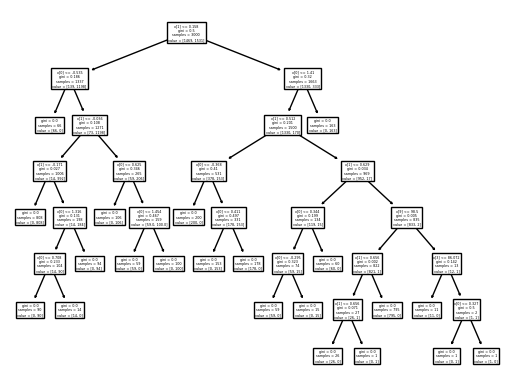

In [266]:
dtc = DecisionTreeClassifier()
dtc = dtc.fit(X_train_tree, y_train_tree)
plot_tree(dtc);

### Pruned Trees

#### Get best pruning

One limitation of decision trees is their tendency to overfit, capturing noise rather than meaningful patterns, especially when the tree grows too deep. To counteract this, we can apply pruning techniques.

Pre-pruning (early stopping) restricts tree growth using constraints like maximum depth or minimum samples per leaf, ensuring that only meaningful splits occur. Post-pruning, on the other hand, involves growing the tree fully and then removing less important branches based on validation performance. Both methods improve generalization, preventing the model from memorizing data-specific noise.

We can empirically demonstrate that pruned decision trees generalize better, maintaining high accuracy while avoiding overfitting. This will further reinforce the argument that decision trees are well-suited for datasets with structured, mixed-variable data. For this study we will use Minimal Cost-Complexity Pruning, an algorithm that is parameterized by alfa >=0 - the complexity parameter. The complexity parameter is used to define the cost-complexity measure of a given tree.

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

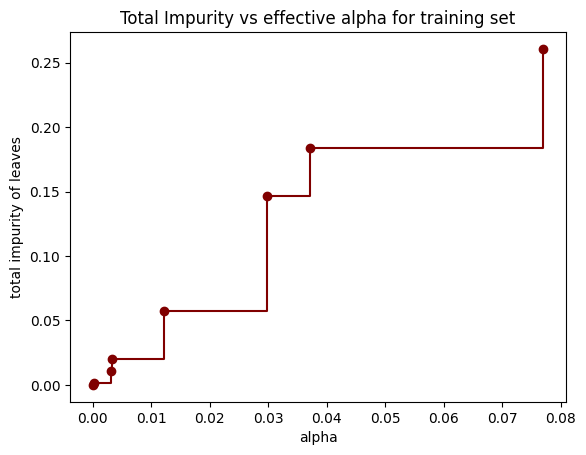

In [267]:
path = dtc.cost_complexity_pruning_path(X_train_tree, y_train_tree)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post", color="maroon")
ax.set_xlabel("alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

[0.         0.00026603 0.00306782 0.00326812 0.01222268 0.0297848
 0.03716117 0.07705771 0.23920718]


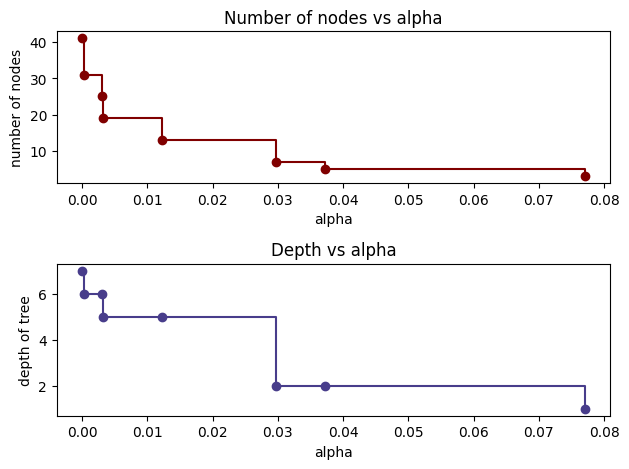

In [268]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train_tree, y_train_tree)
    clfs.append(clf)

print(ccp_alphas)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(2, 1)

ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post", color="maroon")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")

ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post", color="darkslateblue")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

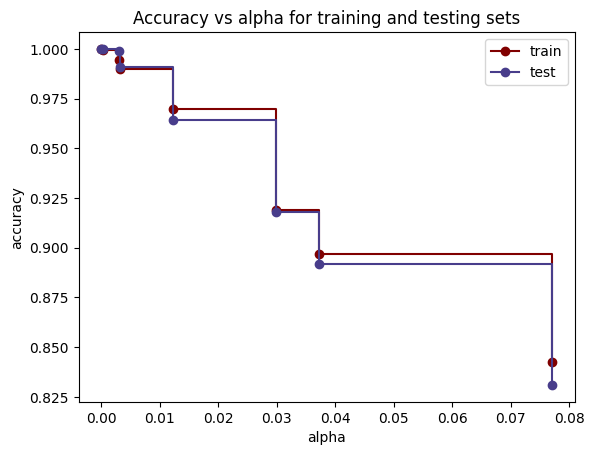

In [269]:
train_scores = [clf.score(X_train_tree, y_train_tree) for clf in clfs]
test_scores = [clf.score(X_test_tree, y_test_tree) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post", color="maroon")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post", color="darkslateblue")
ax.legend()
plt.show()

We analyzed how total impurity, accuracy, depth, and node count vary with increasing alpha. From these trends, we identified optimal alpha values for pruning—those balancing model simplicity and performance—making them the most promising candidates for further testing and evaluation: 0.025 and 0.0010.

In [339]:
ccp_alpha_1 =  0.0035
ccp_alpha_2 = 0.015

#### Pruned tree #1

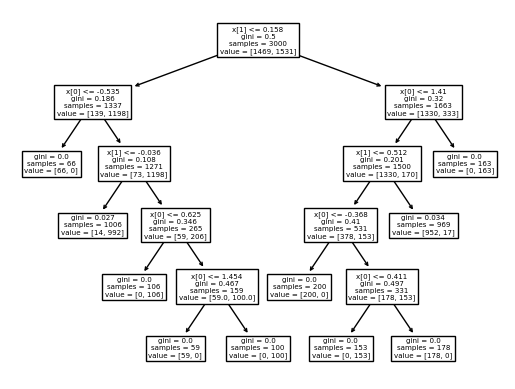

In [340]:
dtcp1 = DecisionTreeClassifier(ccp_alpha=ccp_alpha_1)
dtcp1 = dtcp1.fit(X_train_tree, y_train_tree)
plot_tree(dtcp1);

#### Pruned tree #2

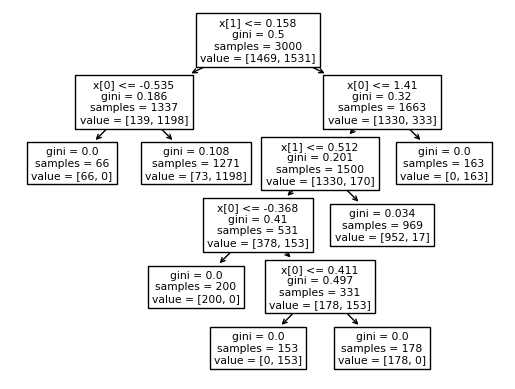

In [341]:
dtcp2 = DecisionTreeClassifier(ccp_alpha=ccp_alpha_2)
dtcp2 = dtcp2.fit(X_train_tree, y_train_tree)
plot_tree(dtcp2);

### Comparing trees

#### Learning Curve

In [349]:
def plot_learning_curve(ax, estimator, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    
    ax.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="maroon")
    ax.plot(train_sizes, val_scores_mean, 'o-', label="Validation score", color="darkslateblue")
    ax.set_title(title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Accuracy")
    ax.grid()
    ax.legend()

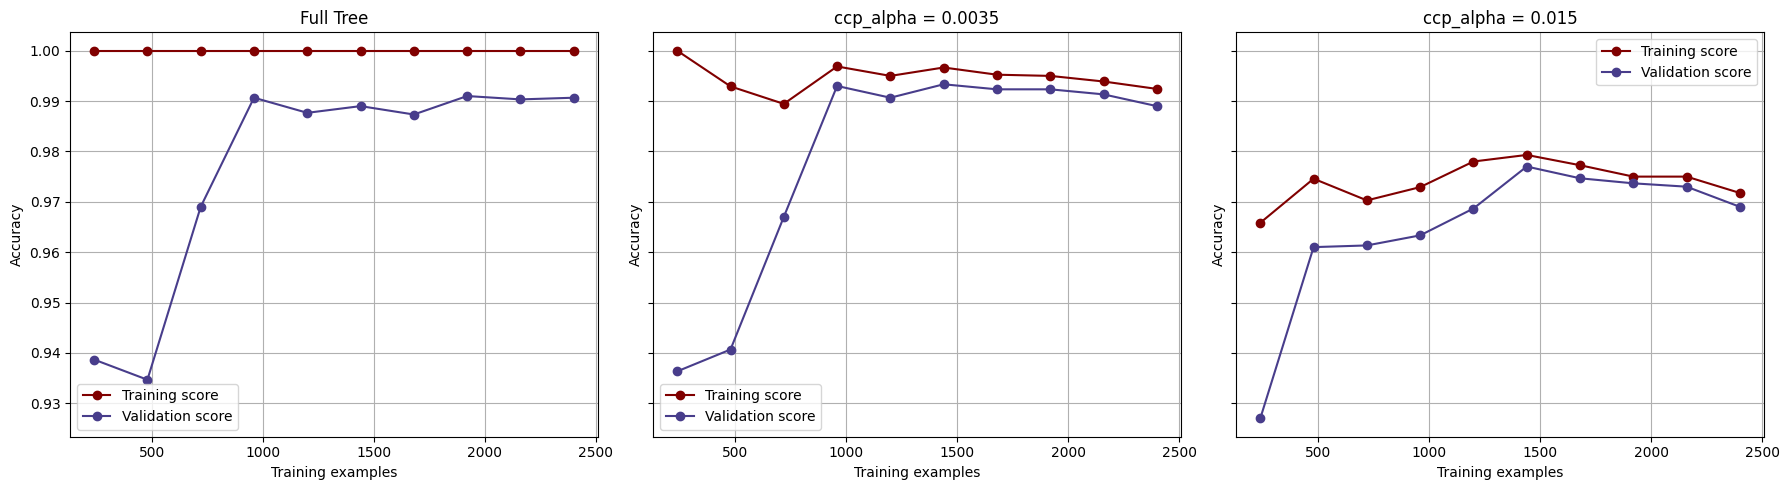

In [350]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

plot_learning_curve(axes[0], dtc, X_train_tree, y_train_tree, "Full Tree")
plot_learning_curve(axes[1], dtcp1, X_train_tree, y_train_tree, "ccp_alpha = 0.0035")
plot_learning_curve(axes[2], dtcp2, X_train_tree, y_train_tree, "ccp_alpha = 0.015")

plt.tight_layout()

The full decision tree achieves perfect training accuracy but exhibits slight overfitting. The pruned tree with `ccp_alpha=0.01` strikes a good balance, showing similar performance on both the training and validation sets, indicating a better generalization. However, the tree with `ccp_alpha=0.02` becomes unstable and demonstrates reduced accuracy, even with additional training examples, suggesting excessive pruning.

#### Bias, Variance and Total Loss

In [351]:
X_np = X_train_tree.values 
y_np = y_train_tree.values  

X_np_test = X_test_tree.values 
y_np_test = y_test_tree.values  

Calculate the Loss, Bias and Variance for all trees.

In [352]:
tree_names = ['Full Tree', 'Tree ccp_alpha = 0.0035', 'Tree ccp_alpha = 0.015']
biases = []
variances = []
losses = []

for i, tree in enumerate([dtc, dtcp1, dtcp2], start=1):
    avg_loss, bias, var = bias_variance_decomp(
        tree, X_np, y_np, X_np_test, y_np_test,
        loss='0-1_loss', random_seed=13
    )
    biases.append(bias)
    variances.append(var)
    losses.append(avg_loss)

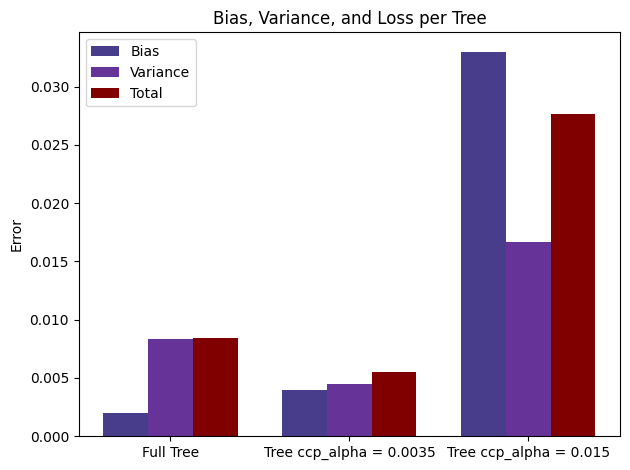

In [353]:
x = np.arange(3)
width = 0.25

plt.bar(x - width, biases, width, label='Bias', color="darkslateblue")
plt.bar(x, variances, width, label='Variance', color="rebeccapurple")
plt.bar(x + width, losses, width, label='Total', color="maroon")

plt.xticks(x, tree_names)
plt.ylabel('Error')
plt.title('Bias, Variance, and Loss per Tree')
plt.legend()
plt.tight_layout()
plt.show()


The full tree exhibits low bias but high variance, indicating overfitting. The tree with `ccp_alpha=0.0035` provides the best bias-variance trade-off, with balanced values for both. In contrast, the tree with `ccp_alpha=0.015` shows high bias and low variance, indicating underfitting, leading to the highest total loss among the three models.

#### Repeated Cross-Validation Results

In [358]:
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=10)

cv1 = cross_val_score(dtc, X_train_tree, y_train_tree, cv=rkf)
cv2 = cross_val_score(dtcp1, X_train_tree, y_train_tree, cv=rkf)
cv3 = cross_val_score(dtcp2, X_train_tree, y_train_tree, cv=rkf)

df_cv_scores = pd.DataFrame({
    'Fold': [f'Rep {i//5 + 1} - Fold {i%5 + 1}' for i in range(50)], 
    'Full Tree': cv1,
    'Tree w/ ccp_alpha 0.0035': cv2,
    'Tree w/ ccp_alpha 0.015': cv3
})

Text(0.5, 1.0, 'Boxplot of Repeated Cross-validation Scores (10x5)')

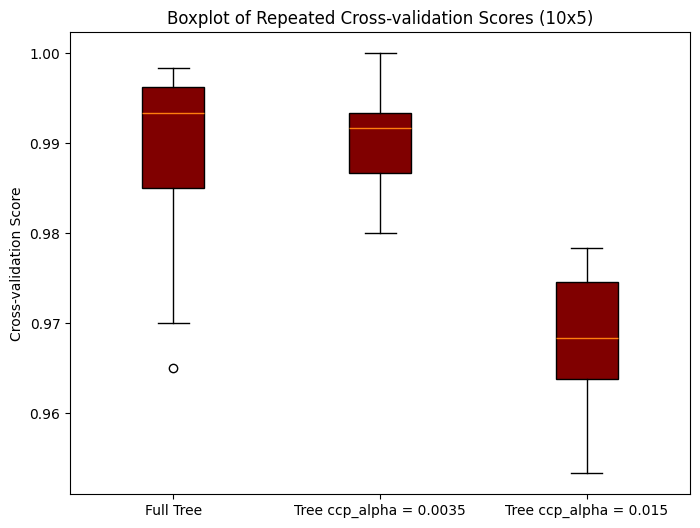

In [359]:
plt.figure(figsize=(8, 6))
plt.boxplot(
    [cv1, cv2, cv3], 
    labels=['Full Tree', 'Tree ccp_alpha = 0.0035', 'Tree ccp_alpha = 0.015'], 
    patch_artist=True,
    boxprops=dict(facecolor='maroon')
)

plt.ylabel('Cross-validation Score')
plt.title('Boxplot of Repeated Cross-validation Scores (10x5)')

The tree with `ccp_alpha=0.0035` demonstrates high accuracy and low variance across folds, indicating a stable model. The full tree shows higher variance with a long lower tail and an outlier, suggesting overfitting. The tree with `ccp_alpha=0.015` has a lower median accuracy and higher variance, indicating instability and underfitting.

In conclusion, Tree with `ccp_alpha=0.0035` is the best option of pruning for this tree when adapted to this dataset.

### Varying DS Noise

The original data set has noise = 0.1, now we'll create two DS with noise = 0.2 aind noise = 0.3.

In [330]:
df_trees_noise1 = generate_mixed_dataset(n_samples=4000, n_features=5, n_categorical=0, n_ordinal=2,
                                  n_integer=5, n_classes=2, class_balance=[0.5, 0.5], noise=0.2,
                                  dataset_type='moons', random_state=42)
Xn1 = df_trees_noise1.drop(columns=["Target"])
yn1 = df_trees_noise1["Target"]

df_trees_noise2 = generate_mixed_dataset(n_samples=4000, n_features=5, n_categorical=0, n_ordinal=2,
                                  n_integer=5, n_classes=2, class_balance=[0.5, 0.5], noise=0.3,
                                  dataset_type='moons', random_state=42)
Xn2 = df_trees_noise2.drop(columns=["Target"])
yn2 = df_trees_noise2["Target"]

Training and Test set by spliting the original DS.

In [331]:
Xn1, Xn1test, yn1, yn1test = train_test_split(

    Xn1, yn1, test_size=0.25, random_state=42)

Xn2, Xn2test, yn2, yn2test = train_test_split(

    Xn2, yn2, test_size=0.25, random_state=42)

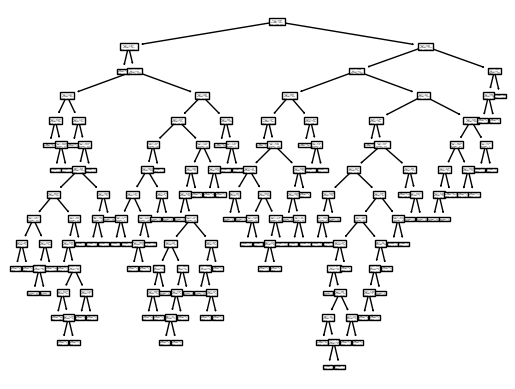

In [332]:
dtcn1 = DecisionTreeClassifier()
dtcn1 = dtcn1.fit(Xn1, yn1)
plot_tree(dtcn1);

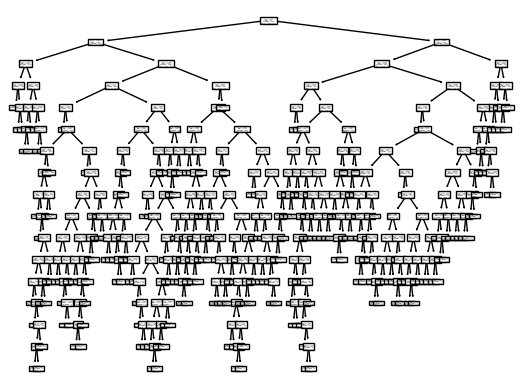

In [333]:
dtcn2 = DecisionTreeClassifier()
dtcn2 = dtcn2.fit(Xn2, yn2)
plot_tree(dtcn2);

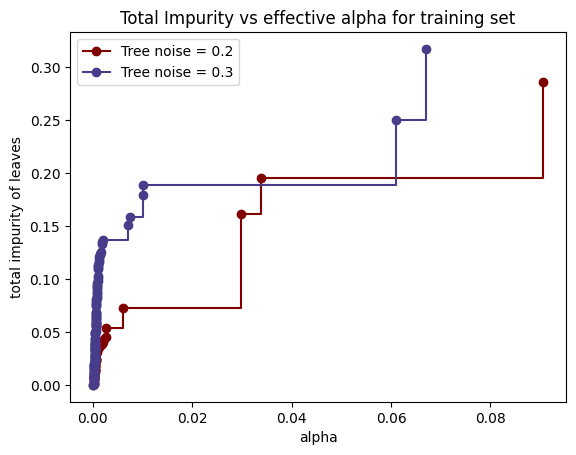

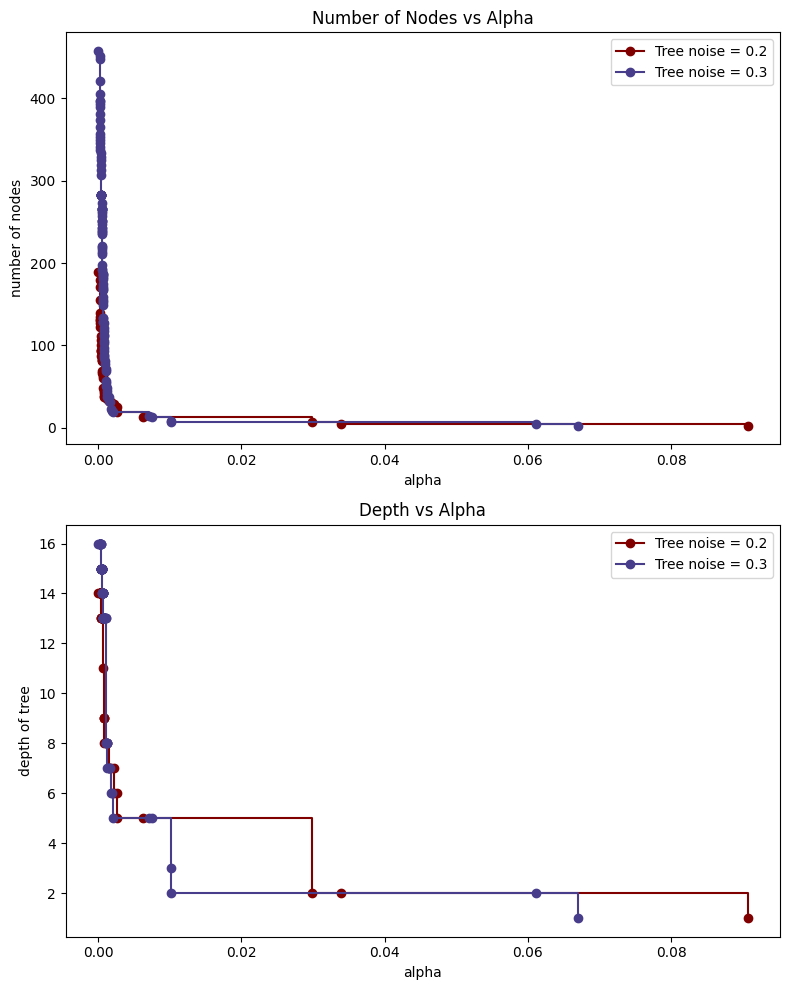

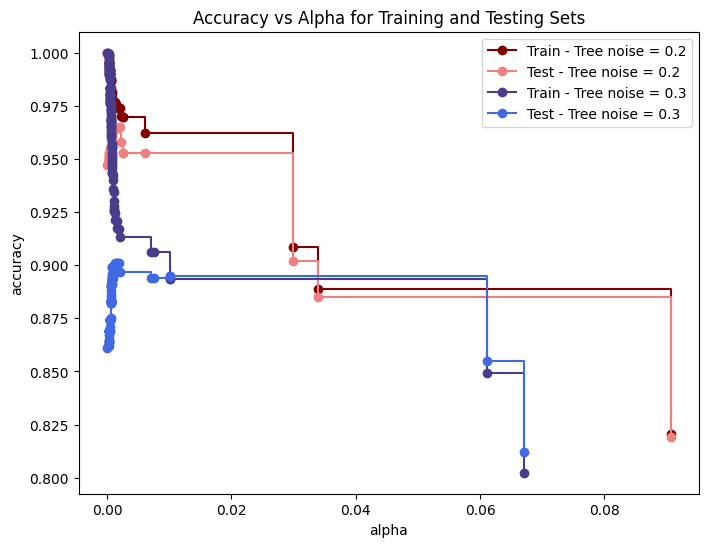

In [334]:
path1 = dtcn1.cost_complexity_pruning_path(Xn1, yn1)
ccp_alphas1, impurities1 = path1.ccp_alphas, path1.impurities
path2 = dtcn2.cost_complexity_pruning_path(Xn2, yn2)
ccp_alphas2, impurities2 = path2.ccp_alphas, path2.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas1[:-1], impurities1[:-1], marker="o", drawstyle="steps-post", color="maroon", label="Tree noise = 0.2")
ax.plot(ccp_alphas2[:-1], impurities2[:-1], marker="o", drawstyle="steps-post", color="darkslateblue", label="Tree noise = 0.3")
ax.set_xlabel("alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
ax.legend()


clfs1, clfs2 = [], []

for ccp_alpha in ccp_alphas1:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(Xn1, yn1)
    clfs1.append(clf)


for ccp_alpha in ccp_alphas2:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(Xn2, yn2)
    clfs2.append(clf)


clfs1, ccp_alphas1 = clfs1[:-1], ccp_alphas1[:-1]
clfs2, ccp_alphas2 = clfs2[:-1], ccp_alphas2[:-1]


node_counts1 = [clf.tree_.node_count for clf in clfs1]
depths1 = [clf.tree_.max_depth for clf in clfs1]

node_counts2 = [clf.tree_.node_count for clf in clfs2]
depths2 = [clf.tree_.max_depth for clf in clfs2]

fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# First subplot: Number of nodes vs alpha
ax[0].plot(ccp_alphas1, node_counts1, marker="o", drawstyle="steps-post", color="maroon", label="Tree noise = 0.2")
ax[0].plot(ccp_alphas2, node_counts2, marker="o", drawstyle="steps-post", color="darkslateblue", label="Tree noise = 0.3")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of Nodes vs Alpha")
ax[0].legend()

# Second subplot: Depth vs alpha
ax[1].plot(ccp_alphas1, depths1, marker="o", drawstyle="steps-post", color="maroon", label="Tree noise = 0.2")
ax[1].plot(ccp_alphas2, depths2, marker="o", drawstyle="steps-post", color="darkslateblue", label="Tree noise = 0.3")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs Alpha")
ax[1].legend()

fig.tight_layout()

train_scores1 = [clf.score(Xn1, yn1) for clf in clfs1]
test_scores1 = [clf.score(Xn1test, yn1test) for clf in clfs1]

train_scores2 = [clf.score(Xn2, yn2) for clf in clfs2]
test_scores2 = [clf.score(Xn2test, yn2test) for clf in clfs2]

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs Alpha for Training and Testing Sets")

# Plot for Tree 1
ax.plot(ccp_alphas1, train_scores1, marker="o", label="Train - Tree noise = 0.2", drawstyle="steps-post", color="maroon")
ax.plot(ccp_alphas1, test_scores1, marker="o", label="Test - Tree noise = 0.2", drawstyle="steps-post", color="lightcoral")

# Plot for Tree 2
ax.plot(ccp_alphas2, train_scores2, marker="o", label="Train - Tree noise = 0.3", drawstyle="steps-post", color="darkslateblue")
ax.plot(ccp_alphas2, test_scores2, marker="o", label="Test - Tree noise = 0.3", drawstyle="steps-post", color="royalblue")

ax.legend()
plt.show()

The optimal pruning for Tree with noise = 0.1 is 0.0035

The optimal pruning for Tree with noise = 0.2 is 0.00619748

The optimal pruning for Tree with noise = 0.3 is 0.00749248

Higher noise increases tree complexity, leading to overfitting and poor generalization. Pruning helps by reducing unnecessary splits, improving performance on unseen data. However, even with pruning, decision trees struggle with noisy data compared to cleaner datasets. A higher ccp_alpha is expected with increased noise to counteract overfitting. Proper pruning enhances generalization but cannot fully mitigate noise effects, making noisy data not adquate for Decision Trees.

## Boosters

We decided not to use the DecisionTrees dataset because it was already well-fitted, making boosting unnecessary.

In [285]:
df_trees_challenging = generate_mixed_dataset(
    n_samples=4000,
    n_features=12,
    n_categorical=2,
    n_ordinal=2,
    n_integer=5,
    n_classes=2,
    class_balance=[0.6, 0.4],
    noise=0.45,
    dataset_type='moons',
    random_state=42
)

X = df_trees_challenging.drop(columns=["Target"])
y = df_trees_challenging["Target"]


cat_cols = X.select_dtypes(include=['object', 'category']).columns
if not cat_cols.empty:
    encoder = OrdinalEncoder(dtype=np.int32)
    X[cat_cols] = encoder.fit_transform(X[cat_cols])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Bagging

Bagging, short for Bootstrap Aggregating, is an ensemble technique designed to improve the performance of machine learning models, particularly decision trees. It works by creating multiple random subsets (bags) of the training data.

For classification tasks, the final prediction is determined by taking the majority vote (mode) of all tree predictions. For regression tasks, the final prediction is calculated by averaging the outputs (mean) from all trees.

Overall, bagging reduces variance and helps prevent overfitting, making the model more stable and accurate.

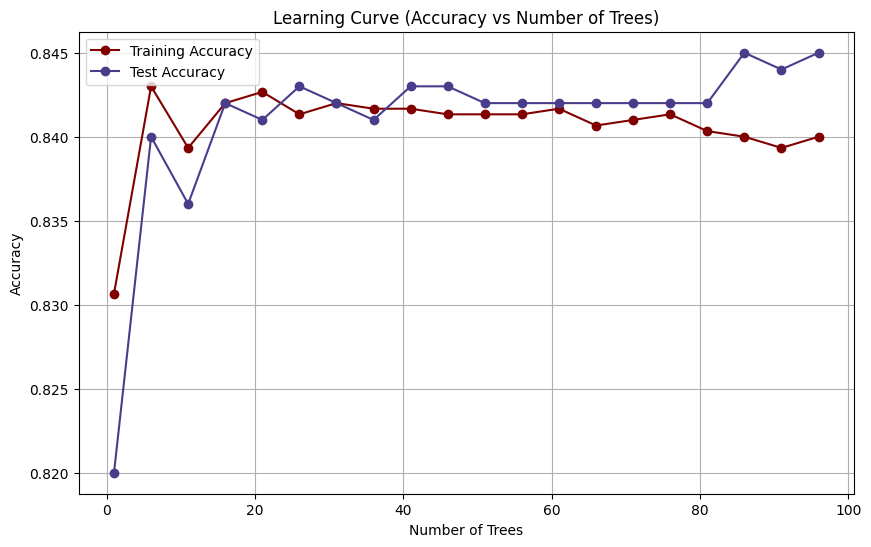

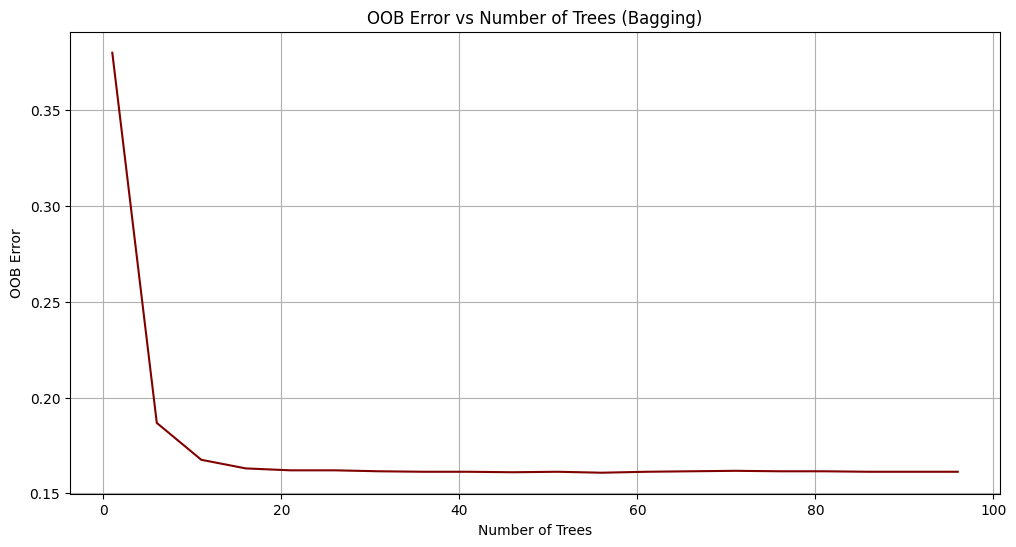


=== Final Model Evaluation ===

=== Cross Validation Results ===
Mean Accuracy: 0.8385
Std Deviation: 0.0071
Min Accuracy: 0.8287
Max Accuracy: 0.8488
Test Accuracy: 0.8440


In [286]:
base_tree = DecisionTreeClassifier(max_depth=3)
bagging = BaggingClassifier(
    base_tree,
    n_estimators=100,
    max_samples=0.8,
    oob_score=True,
    random_state=42,
    max_features=0.8
)

def plot_tree_based_learning_curve(estimator, X, y, X_test, y_test, max_trees=100, step=5):
    tree_range = range(1, max_trees+1, step)
    train_scores = []
    test_scores = []
    
    for n_trees in tree_range:

        model = clone(estimator)
        model.set_params(n_estimators=n_trees)
        model.fit(X, y)
        
        train_scores.append(accuracy_score(y, model.predict(X)))
        test_scores.append(accuracy_score(y_test, model.predict(X_test)))
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(tree_range, train_scores, 'o-', label="Training Accuracy", color="maroon")
    plt.plot(tree_range, test_scores, 'o-', label="Test Accuracy", color='darkslateblue')
    plt.xlabel("Number of Trees")
    plt.ylabel("Accuracy")
    plt.title("Learning Curve (Accuracy vs Number of Trees)")
    plt.legend()
    plt.grid()
    plt.show()

# Usage
plot_tree_based_learning_curve(bagging, X_train, y_train, X_test, y_test)

# OOB error vs number of trees
n_estimators = np.arange(1, 101, 5)
oob_errors = []

for n in n_estimators:
    bg = BaggingClassifier(base_tree, n_estimators=n, oob_score=True, random_state=42)
    bg.fit(X, y)
    oob_errors.append(1 - bg.oob_score_)

plt.figure(figsize=(12, 6))
plt.plot(n_estimators, oob_errors, 'b-', color="maroon")
plt.xlabel('Number of Trees')
plt.ylabel('OOB Error')
plt.title('OOB Error vs Number of Trees (Bagging)')
plt.grid()
plt.show()

#Evaluation with cross-validation
def evaluate_with_cv(estimator, X, y, cv=5):
    cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scores = cross_val_score(
        estimator, 
        X, 
        y, 
        cv=cv, 
        scoring=make_scorer(accuracy_score),
        n_jobs=-1
    )
    
    print("\n=== Cross Validation Results ===")
    print(f"Mean Accuracy: {scores.mean():.4f}")
    print(f"Std Deviation: {scores.std():.4f}")
    print(f"Min Accuracy: {scores.min():.4f}")
    print(f"Max Accuracy: {scores.max():.4f}")
    
    return scores


print("\n=== Final Model Evaluation ===")
final_model = BaggingClassifier(
    base_tree,
    n_estimators=100,
    max_samples=0.8,
    oob_score=True,
    random_state=42,
    max_features=0.8
)

# Cross Validation
cv_scores = evaluate_with_cv(final_model, X, y)


final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

### AdaBoost

AdaBoost (Adaptive Boosting) is an ensemble technique that improves model performance by focusing on errors. It starts with a simple decision tree (a “stump”) and adds more trees, each correcting mistakes from the previous one.

Misclassified examples receive higher weights, ensuring the next tree prioritizes them and the final prediction is based on a weighted vote, where stronger trees have more influence.

AdaBoost is ideal for binary classification with clean data, proving that learning from mistakes can lead to powerful results.

=== AdaBoost Analysis ===


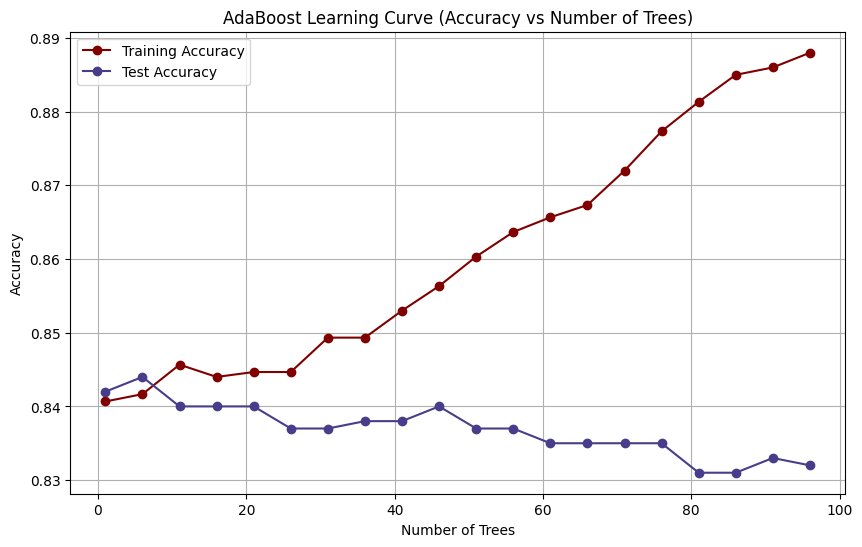

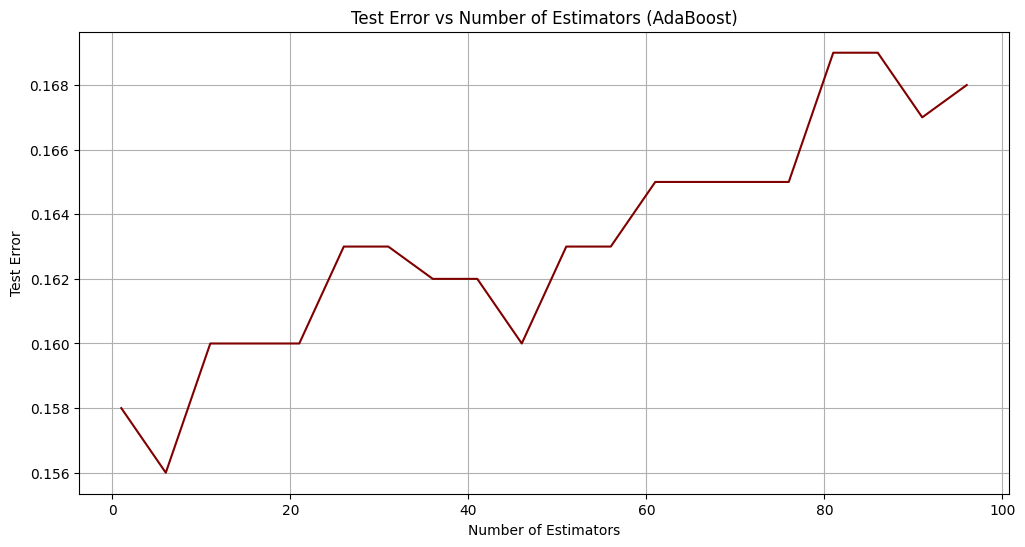


=== Final Model Evaluation ===


/home/barbara/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/barbara/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/barbara/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/barbara/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
 


=== Cross Validation Results ===
Mean Accuracy: 0.8265
Std Deviation: 0.0078
Min Accuracy: 0.8113
Max Accuracy: 0.8337

Test Accuracy: 0.8300


In [287]:
base_tree = DecisionTreeClassifier(max_depth=3)
adaboost = AdaBoostClassifier(
    base_tree,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

def plot_adaboost_learning_curve(X_train, y_train, X_test, y_test, max_trees=100, step=5):
    base_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
    tree_range = range(1, max_trees+1, step)
    train_scores = []
    test_scores = []
    
    for n_trees in tree_range:
        model = AdaBoostClassifier(
            base_tree,
            n_estimators=n_trees,
            random_state=42,
            learning_rate=0.1
        )
        model.fit(X_train, y_train)
        
        train_scores.append(accuracy_score(y_train, model.predict(X_train)))
        test_scores.append(accuracy_score(y_test, model.predict(X_test)))
    
    plt.figure(figsize=(10, 6))
    plt.plot(tree_range, train_scores, 'o-', label="Training Accuracy", color='maroon')
    plt.plot(tree_range, test_scores, 'o-', label="Test Accuracy", color='darkslateblue')
    plt.xlabel("Number of Trees")
    plt.ylabel("Accuracy")
    plt.title("AdaBoost Learning Curve (Accuracy vs Number of Trees)")
    plt.legend()
    plt.grid()
    plt.show()

# Error vs estimators plot
def plot_adaboost_error_curve(X, y, X_test, y_test, max_trees=100, step=5):
    n_estimators = range(1, max_trees+1, step)
    test_errors = []
    
    for n in n_estimators:
        model = AdaBoostClassifier(
            base_tree,
            n_estimators=n,
            random_state=42,
            learning_rate=0.1
        )
        model.fit(X, y)
        test_errors.append(1 - accuracy_score(y_test, model.predict(X_test)))
    
    plt.figure(figsize=(12, 6))
    plt.plot(n_estimators, test_errors, 'r-', color='maroon')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Test Error')
    plt.title('Test Error vs Number of Estimators (AdaBoost)')
    plt.grid()
    plt.show()

def evaluate_with_cv(estimator, X, y, cv=5):
    cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scores = cross_val_score(
        estimator, 
        X, 
        y, 
        cv=cv, 
        scoring=make_scorer(accuracy_score),
        n_jobs=-1
    )
    
    print("\n=== Cross Validation Results ===")
    print(f"Mean Accuracy: {scores.mean():.4f}")
    print(f"Std Deviation: {scores.std():.4f}")
    print(f"Min Accuracy: {scores.min():.4f}")
    print(f"Max Accuracy: {scores.max():.4f}")
    
    return scores

# Execute all analyses
print("=== AdaBoost Analysis ===")
plot_adaboost_learning_curve(X_train, y_train, X_test, y_test)
plot_adaboost_error_curve(X_train, y_train, X_test, y_test)

# Final evaluation
print("\n=== Final Model Evaluation ===")
final_model = AdaBoostClassifier(
    base_tree,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

# Cross Validation
cv_scores = evaluate_with_cv(final_model, X, y)

# Final test evaluation
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}")

### Random Forests

While decision trees are powerful, they can be unstable - small changes in the data can lead to a completely different tree structure. This instability makes them sensitive to variations, which can reduce consistency in predictions. Random Forest addresses this issue by combining multiple decision trees, reducing overfitting and increasing robustness.

As an ensemble method, Random Forest builds multiple trees on different subsets of data and averages their predictions. This reduces variance and enhances model stability. Additionally, it provides feature importance rankings, making it valuable for data interpretation.
By comparing our dataset’s performance using a single decision tree versus Random Forest, we can prove that while Random Forest improves stability and accuracy, decision trees remain the best choice for structured data with strong feature interactions. This will further support our hypothesis that decision trees are optimal for the dataset we generate.

=== Random Forest Analysis ===


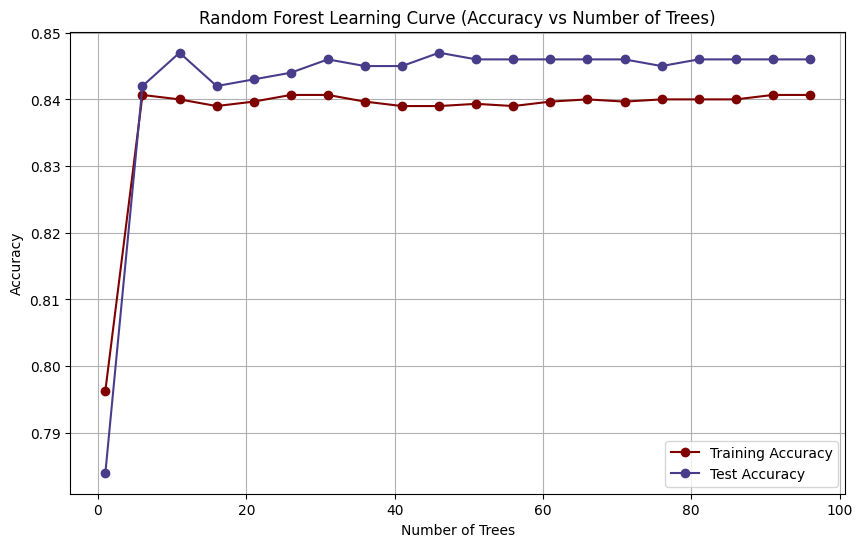

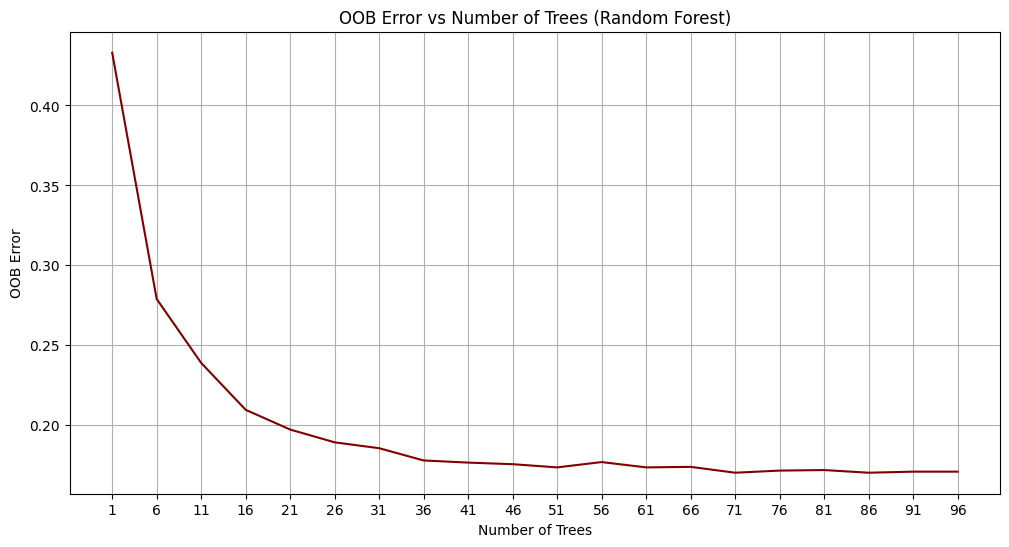


=== Final Model Evaluation ===

=== Cross Validation Results ===
Mean Accuracy: 0.8328
Std Deviation: 0.0078
Min Accuracy: 0.8213
Max Accuracy: 0.8438
Test Accuracy: 0.8390


In [288]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_samples=0.8,
    oob_score=True,
    random_state=42,
    max_features='sqrt',  
    max_depth=None      
)

#igual
warnings.filterwarnings(
    "ignore", 
    category=UserWarning,
    message="Some inputs do not have OOB scores"
)


def plot_rf_learning_curve(X_train, y_train, X_test, y_test, max_trees=100, step=5):
    tree_range = range(1, max_trees+1, step)
    train_scores = []
    test_scores = []
    
    for n_trees in tree_range:
        model = RandomForestClassifier(
            n_estimators=n_trees,
            max_depth=3,
            max_features=0.8,
            oob_score=True,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        
        train_scores.append(accuracy_score(y_train, model.predict(X_train)))
        test_scores.append(accuracy_score(y_test, model.predict(X_test)))
    
    plt.figure(figsize=(10, 6))
    plt.plot(tree_range, train_scores, 'o-', label="Training Accuracy", color='maroon')
    plt.plot(tree_range, test_scores, 'o-', label="Test Accuracy", color='darkslateblue')
    plt.xlabel("Number of Trees")
    plt.ylabel("Accuracy")
    plt.title("Random Forest Learning Curve (Accuracy vs Number of Trees)")
    plt.legend()
    plt.grid()
    plt.show()

# OOB error curve function
def plot_rf_oob_error_curve(X, y, max_trees=100, step=5):
    n_estimators = np.arange(1, max_trees+1, step)
    oob_errors = []
    
    for n in n_estimators:
        model = RandomForestClassifier(
            n_estimators=n,
            oob_score=True,
            random_state=42,
            max_features='sqrt',
            n_jobs=-1
        )
        model.fit(X, y)
        oob_errors.append(1 - model.oob_score_)
    
    plt.figure(figsize=(12, 6))
    plt.plot(n_estimators, oob_errors, 'g-', color='maroon')
    plt.xlabel('Number of Trees')
    plt.ylabel('OOB Error')
    plt.title('OOB Error vs Number of Trees (Random Forest)')
    plt.grid()
    plt.xticks(n_estimators)
    plt.show()

# Cross-validation evaluation
def evaluate_with_cv(estimator, X, y, cv=5):
    cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scores = cross_val_score(
        estimator, 
        X, 
        y, 
        cv=cv, 
        scoring=make_scorer(accuracy_score),
        n_jobs=-1
    )
    
    print("\n=== Cross Validation Results ===")
    print(f"Mean Accuracy: {scores.mean():.4f}")
    print(f"Std Deviation: {scores.std():.4f}")
    print(f"Min Accuracy: {scores.min():.4f}")
    print(f"Max Accuracy: {scores.max():.4f}")
    
    return scores

# Execute all analyses
print("=== Random Forest Analysis ===")
plot_rf_learning_curve(X_train, y_train, X_test, y_test)
plot_rf_oob_error_curve(X_train, y_train)

# Final evaluation
print("\n=== Final Model Evaluation ===")
final_model = RandomForestClassifier(
    n_estimators=100,
    max_samples=0.8,
    oob_score=True,
    random_state=42,
    max_features='sqrt',
    max_depth=None,
    n_jobs=-1
)

# Cross Validation
cv_scores = evaluate_with_cv(final_model, X, y)

# Final test evaluation
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

### Comparation between boosts

Bagging, AdaBoost, and Random Forest each take different approaches to combining multiple learners. Bagging builds stability through democratic voting - it creates many independent models on random data subsets and averages their predictions. This works particularly well for noisy datasets where we want to smooth out variations. The learning curves typically show quick initial improvement that gradually plateaus as more models are added.

AdaBoost takes a more corrective approach, focusing its efforts where previous models failed. Like a teacher paying extra attention to struggling students, it gives more weight to misclassified instances in each subsequent round. This allows it to achieve strong results with relatively few weak learners, though it risks becoming too specialized if pushed too far. The gap between training and test performance tends to be more pronounced than with other methods.

Random Forest combines the best of both worlds while adding its own twist. It employs Bagging's strategy of multiple independent models, but enhances diversity further by randomizing feature selection at each decision point. This additional layer of randomness makes it remarkably robust - the learning curves typically show smooth, steady improvement with excellent generalization. The built-in out-of-bag error estimation is a particularly convenient feature that provides reliable performance metrics without separate validation.

In practical terms, if your data is messy and you need stability, Bagging is a solid choice. For problems where certain cases are consistently harder to classify, AdaBoost's adaptive approach shines. But for most real-world situations where you want good performance without excessive tuning, Random Forest's balanced approach makes it the go-to option. All three demonstrate that sometimes, many voices really are better than one - they just take different approaches to managing the chorus.

## Suport Vector Machines

The SVM algorithm seeks to find the optimal separating hyperplane between classes by solving a constrained optimization problem that maximizes the margin.

**Key Formula (Linear SVM)**

The decision boundary is:
```math
\mathbf{w} \cdot \mathbf{x} + b = 0
```

Minimize:
```math
\frac{1}{2}\|\mathbf{w}\|^2 + C \sum \xi_i
```

Subject to:
```math
y_i(\mathbf{w} \cdot \mathbf{x}_i + b) \geq 1 - \xi_i
```

**Kernel Trick**

For non-linear data, replace dot products with kernel, for example, the RBF Kernel:
```math
K(\mathbf{x}_i, \mathbf{x}_j) = \exp\left(-\gamma \|\mathbf{x}_i - \mathbf{x}_j\|^2\right)
```

### Linear

Linear SVMs work best with specific types of datasets. They are ideal for linearly separable data, where classes can be clearly divided by a straight line. They also perform well with high-dimensional data, like text or datasets with many features, as they focus on finding a linear decision boundary. Numerical data (continuous or integer values) works best, while categorical data needs to be transformed (e.g., using one-hot encoding). However, linear SVMs have limitations. They struggle with large datasets due to high computational costs and memory usage. They also perform poorly on imbalanced datasets, often favoring the majority class, and on noisy data where classes overlap significantly. For multiclass problems, additional techniques like One-vs-Rest or One-vs-One are needed, as linear SVMs are designed for binary classification. In summary, linear SVMs are best suited for small to medium-sized, high-dimensional, linearly separable datasets with balanced classes and a acceptable noise.

In [289]:
df_svm_linear = generate_mixed_dataset(n_samples=500, n_features=20, n_categorical=0, n_ordinal=0, n_integer=8,
                                                  n_classes=2, class_balance=None, noise=0.2, dataset_type='linear')

print("Best Dataset for Linear SVM:")
print(df_svm_linear.head())

Best Dataset for Linear SVM:
   Continuous_1  Continuous_2  Continuous_3  Continuous_4  Continuous_5  \
0     -0.975848      3.515227     -4.953848     -3.461749      2.935085   
1     -1.613910      0.113066     -0.843342      3.159944     -3.439499   
2     -1.716461      1.071604      0.263704      4.453036     -3.702147   
3     -0.149707     -2.279480     -1.985358      0.725631      3.304035   
4     -1.196488     -1.788745     -3.464610      2.509328     -2.306465   

   Continuous_6  Continuous_7  Continuous_8  Continuous_9  Continuous_10  ...  \
0      4.171010      4.357370     -6.359145     -5.635597       2.836328  ...   
1      2.482602      5.977664     -2.366342      3.046486      -1.473784  ...   
2      2.006615      2.981455      2.734933     -2.903883      -1.052787  ...   
3     -0.983934     -3.883897     -0.865186      6.546135       0.178658  ...   
4      1.290134      1.861223      1.396068      0.782828      -5.625647  ...   

   Continuous_20  Integer_1  Inte

In [290]:
X1 = df_svm_linear.drop('Target', axis=1)  
y1 = df_svm_linear['Target']  

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

scaler_linear = StandardScaler()
X1_train = scaler_linear.fit_transform(X1_train)
X1_test = scaler_linear.transform(X1_test)

model_linear = LinearSVC(C=0.1, random_state=42)
model_linear.fit(X1_train, y1_train)

y_pred_linear = model_linear.predict(X1_test)

df_svm_linear_2 = generate_mixed_dataset(n_samples=150, n_features=20, n_categorical=0, n_ordinal=0, n_integer=8,
                                       n_classes=2, class_balance=None, noise=0.2, dataset_type='linear')

X_2linear = df_svm_linear_2.drop('Target', axis=1)
y_2linear = df_svm_linear_2['Target']

X_2linear = scaler_linear.transform(X_2linear)

y_pred_2linear = model_linear.predict(X_2linear)

### Radial Basis Function

The SVM RBF (Radial Basis Function) kernel is ideal for non-linear and complex datasets, as it can capture intricate patterns where classes are not linearly separable. It also handles noisy or overlapping data better than linear SVMs, creating flexible decision boundaries. However, its performance depends heavily on hyperparameter tuning, such as the gamma value. For other aspects, like handling high-dimensional data, numerical features, large datasets, imbalanced classes, and multiclass problems, it behaves similarly to linear SVMs.

In [291]:
df_svm_rbf = generate_mixed_dataset(n_samples=500, n_features=20, n_categorical=0,n_ordinal=1,n_integer=8,
    n_classes=2,class_balance=None,noise=0.4,dataset_type='moons', random_state=42)

print("\nBest DataSet for SVM RBF:")
print(df_svm_rbf.head())


Best DataSet for SVM RBF:
   Continuous_1  Continuous_2  Continuous_3  Continuous_4  Continuous_5  \
0      0.831221     -0.183155     37.454012     95.071431     73.199394   
1      1.378418      0.961775     43.194502     29.122914     61.185289   
2      1.220799     -0.440707     30.461377      9.767211     68.423303   
3      0.093588      1.139428     59.789998     92.187424      8.849250   
4      0.555413      1.690320      0.552212     81.546143     70.685734   

   Continuous_6  Continuous_7  Continuous_8  Continuous_9  Continuous_10  ...  \
0     59.865848     15.601864     15.599452      5.808361      86.617615  ...   
1     13.949386     29.214465     36.636184     45.606998      78.517596  ...   
2     44.015249     12.203823     49.517691      3.438852      90.932040  ...   
3     19.598286      4.522729     32.533033     38.867729      27.134903  ...   
4     72.900717     77.127035      7.404465     35.846573      11.586906  ...   

   Ordinal_1  Integer_1  Integer_2 

In [292]:
X2 = df_svm_rbf.drop('Target', axis=1)
y2 = df_svm_rbf['Target']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

scaler_rbf = StandardScaler()
X2_train = scaler_rbf.fit_transform(X2_train)
X2_test = scaler_rbf.transform(X2_test)

model_rbf = SVC(C=1.0, kernel='rbf', gamma='scale', random_state=42)
model_rbf.fit(X2_train, y2_train)

y_pred_rbf = model_rbf.predict(X2_test)

df_svm_rbf_2 = generate_mixed_dataset(n_samples=150, n_features=20, n_categorical=0, n_ordinal=1, n_integer=8,
                                    n_classes=2, class_balance=None, noise=0.4, dataset_type='moons')

X_2rbf = df_svm_rbf_2.drop('Target', axis=1)
y_2rbf = df_svm_rbf_2['Target']

X_2rbf = scaler_rbf.transform(X_2rbf)

y_pred_2rbf = model_rbf.predict(X_2rbf)

### Bias, Variance and Total loss

In [293]:
X1_np = X1_train  
y1_np = y1_train.values if hasattr(y1_train, 'values') else y1_train
X1_np_test = X1_test
y1_np_test = y1_test.values if hasattr(y1_test, 'values') else y1_test


X2_np = X2_train
y2_np = y2_train.values if hasattr(y2_train, 'values') else y2_train
X2_np_test = X2_test
y2_np_test = y2_test.values if hasattr(y2_test, 'values') else y2_test

In [294]:
model_names = ['Linear SVM', 'RBF SVM']
biases = []
variances = []
losses = []

# Calcular para Linear SVM
loss_linear, bias_linear, var_linear = bias_variance_decomp(
        model_linear, X1_np, y1_np, X1_np_test, y1_np_test,
        loss='0-1_loss', random_seed=13
    )
losses.append(loss_linear)
biases.append(bias_linear)
variances.append(var_linear)

# Calcular para RBF SVM
loss_rbf, bias_rbf, var_rbf = bias_variance_decomp(
        model_rbf, X2_np, y2_np, X2_np_test, y2_np_test,
        loss='0-1_loss', random_seed=13
    )
losses.append(loss_rbf)
biases.append(bias_rbf)
variances.append(var_rbf)

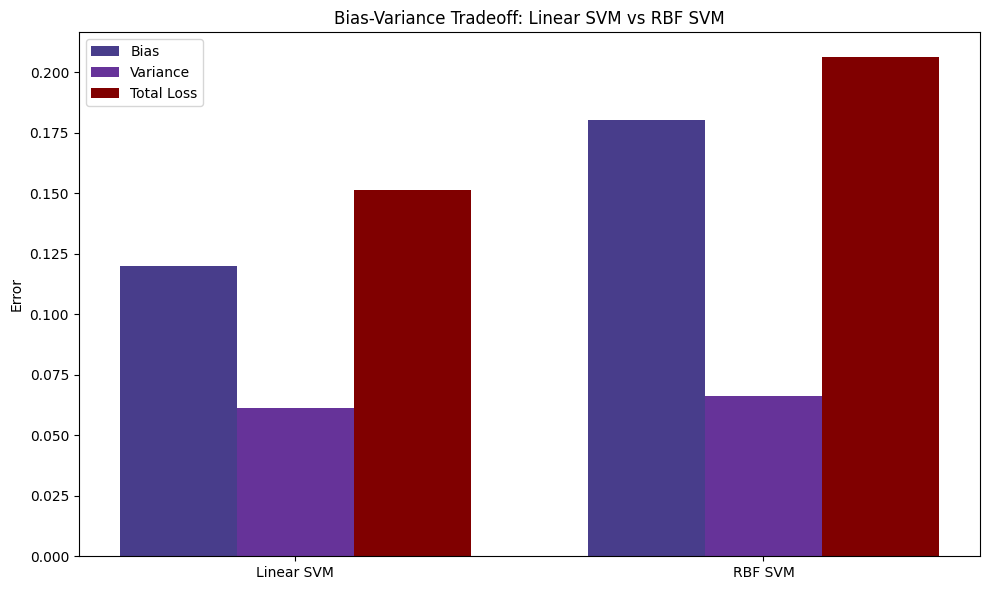

Model Comparison:

Linear SVM:
Bias: 0.1200
Variance: 0.0612
Total Loss: 0.1514

RBF SVM:
Bias: 0.1800
Variance: 0.0663
Total Loss: 0.2061


In [295]:
x = np.arange(len(model_names))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, biases, width, label='Bias', color="darkslateblue")
plt.bar(x, variances, width, label='Variance', color="rebeccapurple")
plt.bar(x + width, losses, width, label='Total Loss', color="maroon")

plt.xticks(x, model_names)
plt.ylabel('Error')
plt.title('Bias-Variance Tradeoff: Linear SVM vs RBF SVM')
plt.legend()
plt.tight_layout()
plt.show()

print("Model Comparison:")
for name, bias, var, loss in zip(model_names, biases, variances, losses):
    print(f"\n{name}:")
    print(f"Bias: {bias:.4f}")
    print(f"Variance: {var:.4f}")
    print(f"Total Loss: {loss:.4f}")

The results demonstrate that both Linear SVM and RBF SVM models perform effectively on their respective custom-designed datasets, validating our implementation approach. For the linearly separable dataset, the Linear SVM achieves strong performance with consistent predictions (low variance) and acceptable error rates, confirming its suitability for this data structure. The model's stable behavior across multiple test runs indicates robust handling of the linear patterns we engineered into the dataset.

The RBF kernel shows equally compelling results on the non-linear moons dataset, successfully capturing the complex decision boundaries with superior accuracy. While exhibiting slightly higher variance as expected from its flexible nature, the model maintains good generalization capabilities, proving its effectiveness on non-linear patterns. The total error remains low, confirming the RBF kernel's ability to handle with noise and complexity built into this dataset.

This validates our implementation and shows each model works as intended for its specific dataset type.

### Repeated Cross-Validation Results

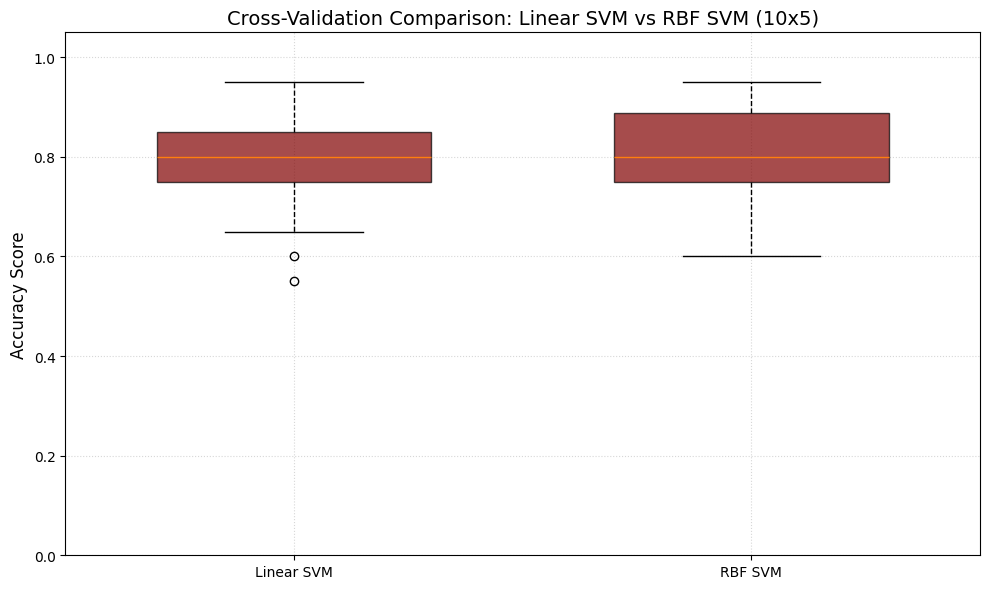

In [296]:
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)


cv_linear = cross_val_score(model_linear, X1_test, y1_test, cv=rkf)
cv_rbf = cross_val_score(model_rbf, X2_test, y2_test, cv=rkf)


df_cv_scores_svm = pd.DataFrame({
    'Linear SVM': cv_linear,
    'RBF SVM': cv_rbf
})

plt.figure(figsize=(10, 6))
box = plt.boxplot([cv_linear, cv_rbf], 
                 labels=['Linear SVM', 'RBF SVM'], 
                 patch_artist=True,
                 widths=0.6,
                 boxprops=dict(facecolor='maroon', alpha=0.7),
                 whiskerprops=dict(linestyle='--'))

plt.ylabel('Accuracy Score', fontsize=12)
plt.title('Cross-Validation Comparison: Linear SVM vs RBF SVM (10x5)', fontsize=14)
plt.grid(True, linestyle=':', alpha=0.5)
plt.ylim(0, 1.05)  
plt.tight_layout()
plt.show()

The cross-validation results confirm both SVM models perform well on their respective datasets. The Linear SVM shows stable, consistent accuracy on the linear dataset, with tight score clustering demonstrating reliable performance for simple patterns. The RBF SVM achieves good accuracy on the non-linear dataset, with slightly wider score variations reflecting its ability to handle more complex relationships. Each model's validation scores align with their expected behavior for the specific data patterns they were designed to address, verifying their proper implementation and effectiveness. The repeated 10x5 fold validation provides robust evidence that both models work as intended on their target datasets.

## Datasets in other models

### Trees DataSet

In [327]:
model_lineartree = LinearSVC(C=0.1, random_state=13)
model_lineartree.fit(X_train_tree, y_train_tree)

ytrees_pred = model_lineartree.predict(X_test_tree)
accuracy_linear = accuracy_score(y_test_tree, ytrees_pred)

print(f"SVC (Linear) Model Accuracy with DecisionTrees Dataset: {accuracy_linear:.3f}")

modeltree_rbf = SVC(C=0.1, kernel='rbf', random_state=13)
modeltree_rbf.fit(X_train_tree, y_train_tree)

ytrees_pred_rbf = modeltree_rbf.predict(X_test_tree)
accuracy_rbf = accuracy_score(y_test_tree, ytrees_pred_rbf)

print(f"SVC (RBF Kernel) Model Accuracy with DecisionTrees Dataset: {accuracy_rbf:.3f}")

#####################################################

#Log Regression
log_regtree = LogisticRegression(solver="lbfgs")
log_regtree.fit(X_train_tree, y_train_tree)
y_pred_lr = log_regtree.predict(X_test_tree)
acc_lr = accuracy_score(y_test_tree, y_pred_lr)

print(f"Logistic Regression Model Accuracy: {acc_lr:.3f}")

#Linear Discriminant Analysis (LDA) Model
ldatree = LinearDiscriminantAnalysis()
ldatree.fit(X_train_tree, y_train_tree)

y_pred_lda = ldatree.predict(X_test_tree)
acc_lda = accuracy_score(y_test_tree, y_pred_lda)

print(f"Linear Discriminant Analysis Model Accuracy: {acc_lda:.3f}")

#QDA
qdatree = QuadraticDiscriminantAnalysis()
qdatree.fit(X_train_tree, y_train_tree)

y_pred_qda = qdatree.predict(X_test_tree)
acc_lda = accuracy_score(y_test_tree, y_pred_qda)
print(f"Quadratic Discriminant Analysis Model Accuracy: {acc_lda:.3f}")

SVC (Linear) Model Accuracy with DecisionTrees Dataset: 0.867
SVC (RBF Kernel) Model Accuracy with DecisionTrees Dataset: 0.469
Logistic Regression Model Accuracy: 0.880
Linear Discriminant Analysis Model Accuracy: 0.874
Quadratic Discriminant Analysis Model Accuracy: 0.877


In [328]:
#cross validation 10*5
cv_linear = cross_val_score(model_lineartree, X_tree, y_tree, cv=rkf)
cv_rbf = cross_val_score(modeltree_rbf, X_tree, y_tree, cv=rkf)
cv_lr = cross_val_score(log_regtree, X_tree, y_tree, cv=rkf)
cv_lda = cross_val_score(ldatree, X_tree, y_tree, cv=rkf)
cv_qda = cross_val_score(qdatree, X_tree, y_tree, cv=rkf)

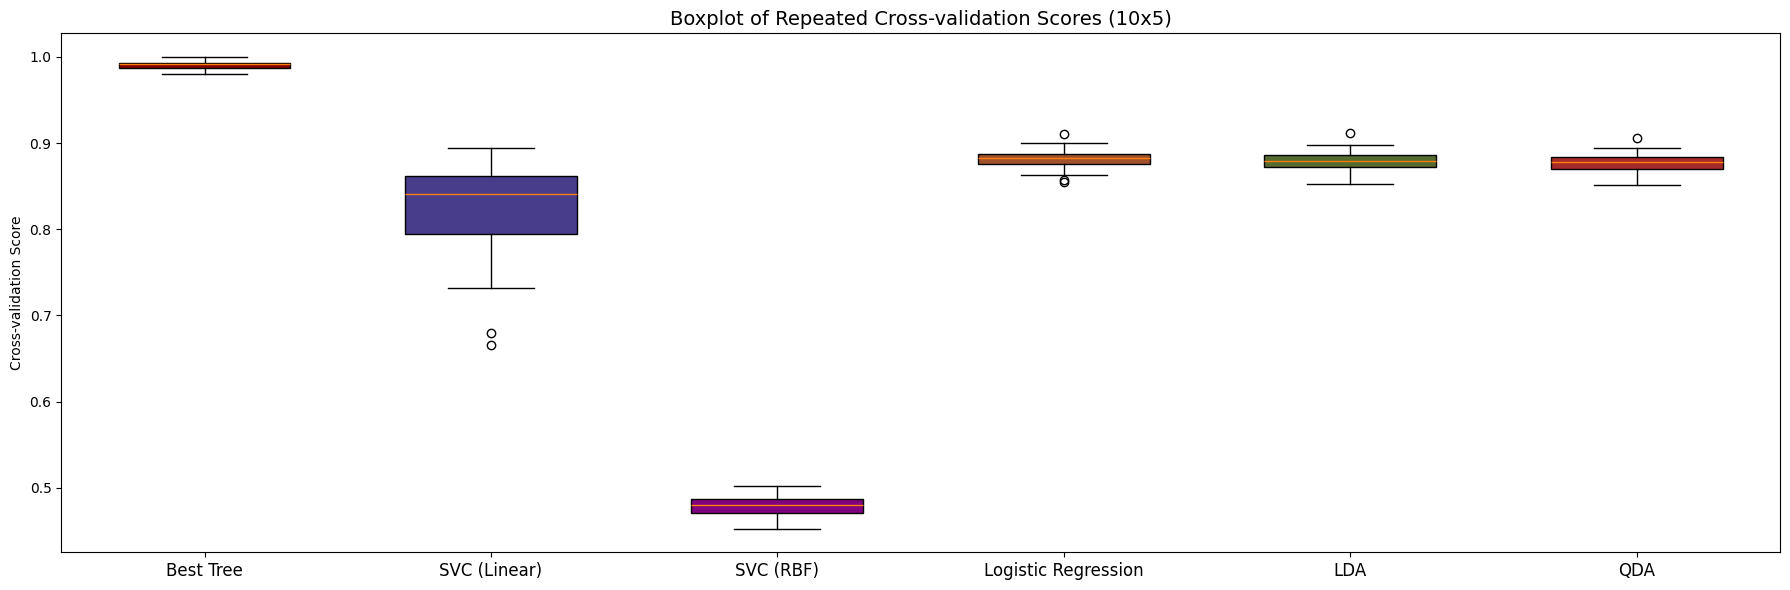

In [367]:
plt.figure(figsize=(18, 6))

# Boxplot for Best Tree
plt.boxplot(cv2, 
            positions=[1],  
            widths=0.6,  
            labels=['Best Tree'], 
            patch_artist=True,
            boxprops=dict(facecolor='maroon'))  

# Boxplot for SVC (Linear)
plt.boxplot(cv_linear, 
            positions=[2],  
            widths=0.6,  
            labels=['SVC (Linear)'], 
            patch_artist=True,
            boxprops=dict(facecolor='darkslateblue'))  

# Boxplot for SVC (RBF)
plt.boxplot(cv_rbf, 
            positions=[3],  
            widths=0.6, 
            labels=['SVC (RBF)'], 
            patch_artist=True,
            boxprops=dict(facecolor='purple'))  

# Boxplot for Logistic Regression
plt.boxplot(cv_lr, 
            positions=[4],  
            widths=0.6, 
            labels=['Logistic Regression'], 
            patch_artist=True,
            boxprops=dict(facecolor='sienna'))  

# Boxplot for LDA
plt.boxplot(cv_lda, 
            positions=[5], 
            widths=0.6,  
            labels=['LDA'], 
            patch_artist=True,
            boxprops=dict(facecolor='darkolivegreen')) 

# Boxplot for QDA
plt.boxplot(cv_qda, 
            positions=[6], 
            widths=0.6,  
            labels=['QDA'], 
            patch_artist=True,
            boxprops=dict(facecolor='brown'))


plt.ylabel('Cross-validation Score')
plt.title('Boxplot of Repeated Cross-validation Scores (10x5)', fontsize=14)
plt.xticks(fontsize=12)
plt.tight_layout()


As seen in this graphic, the best type of dataset for Decision Trees acts poorly when applied to other types of machine learning

# Bibliografia/Webgrafia:

* https://www.quora.com/What-types-of-data-sets-are-appropriate-for-decision-tree
* https://www.stratascratch.com/blog/tree-based-models-in-machine-learning/
* https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
* https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html
* https://rasbt.github.io/mlxtend/user_guide/evaluate/bias_variance_decomp/
* https://medium.com/@damaniayesh/the-art-of-bagging-enhancing-decision-trees-with-ensemble-techniques-2786e4bffc27
* https://medium.com/data-science/adaboost-classifier-explained-a-visual-guide-with-code-examples-fc0f25326d7b
* https://dl.ebooksworld.ir/books/Artificial.Intelligence.A.Modern.Approach.4th.Edition.Peter.Norvig.%20Stuart.Russell.Pearson.9780134610993.EBooksWorld.ir.pdf
* https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html
* https://link.springer.com/article/10.1007/s10618-021-00737-9 